In [6]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit
import statsmodels.formula.api as smf

# Import et préparation des données

In [3]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [8]:
train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [7]:
dataprep = DataPreparation(train, test, 0.3)
train_prepared, test_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅


KeyboardInterrupt: 

In [9]:
df_train = train_prepared.copy()

In [10]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [11]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

# Modélisation

In [12]:
features = list(df_train.iloc[:,2:7].columns)

In [13]:
formula = f'TARGET ~ {" + ".join(f"C({var})" for var in features)}'

In [14]:
reference_categories = {var : df_train[var].mode()[0] for var in features}

In [15]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')
    else:
        formula_parts.append(f'C({var})')  # Ou simplement 'var' si c'est une variable continue

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [16]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2538339716351152
            Iterations: 67
            Function evaluations: 67
            Gradient evaluations: 67


# Prédiction

In [17]:
pred = logit_model.predict(df_validation[features])

In [18]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

/Users/axel/Documents/École/Université/M2/M2_S1/Challenge_Nexialog/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


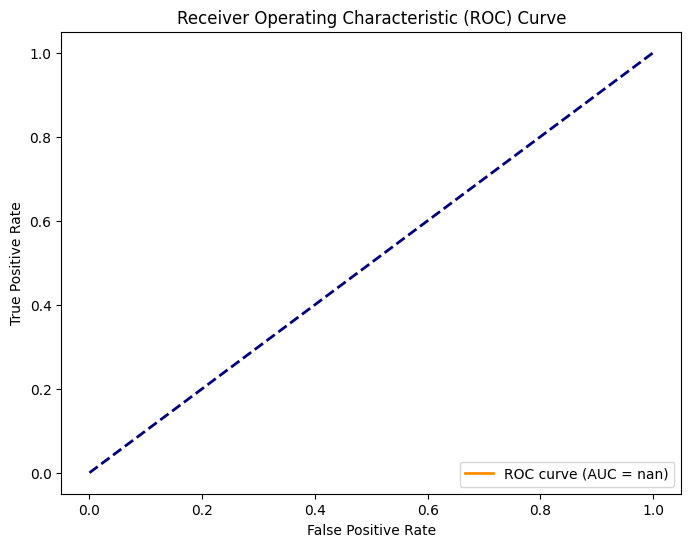

In [19]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

nan

In [21]:
GridScore(df_train, logit_model).compute_grid_score()

,Variable,Modality,Coefficient,P-Value,Normalized Score,Pcentage_Défaut,Pcentage_Classe
0,DAYS_BIRTH_disc_int,[-19590;-13345]_ref,0.00,0.0,0.00,3.10,42.80
1,DAYS_BIRTH_disc_int,[-13344;-7489],0.13,0.0,567.52,3.18,31.49
2,DAYS_BIRTH_disc_int,[-25229;-19591],-0.47,0.0,835.03,1.28,25.71
3,EXT_SOURCE_2_disc_int,[0.51;0.85]_ref,0.00,0.0,0.00,3.07,61.19
4,EXT_SOURCE_2_disc_int,[0.0;0.15],1.40,0.0,1.27,1.17,5.86
5,EXT_SOURCE_2_disc_int,[0.15;0.51],0.66,0.0,331.21,3.31,32.95
6,EXT_SOURCE_1_disc_int,[0.0;0.4]_ref,0.00,0.0,0.00,6.26,71.58
7,EXT_SOURCE_1_disc_int,[0.4;0.67],-0.47,0.0,835.03,0.94,16.95
8,EXT_SOURCE_1_disc_int,[0.67;0.96],-0.84,0.0,1000.00,0.35,11.48
9,AMT_GOODS_PRICE_disc_int,[40500.0;676278.0]_ref,0.00,0.0,0.00,6.16,73.77


# Grid Score Avec Contribution (En Développement)

In [172]:
import pandas as pd
import numpy as np
import re

class GridScore2():
    def __init__(self, df, model):
        self.df = df
        self.model = model
        self.variable_pattern = r'C\(([^,]+)'
        self.modality_pattern = r'\[T\.([^\]]+\])'
        self.reference_pattern = r'reference="([^"]+)"'

    def calculate_percentage_default(self, row, data_frame):
        variable = row['Variable']
        modality = row['Modality']
        if modality.isdigit():
            modality = int(modality)
        if '_ref' in modality:
            modality = modality.split('_ref')[0]

        default_count = data_frame[data_frame[variable] == modality]["TARGET"].sum()
        total_count = data_frame.shape[0]
        return round((default_count / total_count) * 100, 2)

    def calculate_pcentage_class(self, row, data_frame):
        variable = row['Variable']
        modality = row['Modality']
        if modality.isdigit():
            modality = int(modality)
        
        if '_ref' in modality:
            modality = modality.split('_ref')[0]

        default_count = data_frame[data_frame[variable] == modality].shape[0]
        total_count = data_frame.shape[0]
        return round((default_count / total_count) * 100, 2)
    
    def calculate_contribution(self, score_card):
        mean_scores = score_card.groupby('Variable')['Normalized Score'].mean().to_dict()
        population_parts = score_card['Pcentage_Classe']
        modalities = score_card.groupby('Variable')["Modality"].nunique().to_dict()

        score_card['Contribution'] = 0
        
        for index, row in score_card.iterrows():
            variable = row['Variable']
            modality = row['Modality']
            score = row["Normalized Score"]
            
            # Note moyenne pour la modalité j de la variable i
            mean_score = mean_scores.get(variable, 0)
            # Part de la population pour la modalité j de la variable i
            pop_part = population_parts.get(variable, 0)
            # Nombre total de modalités pour la variable i (à déterminer selon vos données)
            num_modalities = modalities[variable]
            # Nombre total de variables dans le modèle (à déterminer selon vos données)
            num_variables = len(mean_scores)

            ci_numerator = np.sqrt(np.sum([(pop_part * (score - mean_score)**2) for j in range(num_modalities)]))
            ci_denominator = np.sqrt(np.sum([np.sum([(population_parts.get(v, 0) * (mean_scores.get(v, 0) - mean_scores.get(v, 0))**2) for v in mean_scores]) for i in range(num_variables)]))
            
            
            ci = ci_numerator / ci_denominator if ci_denominator != 0 else 0

            score_card.at[index, 'Contribution'] = ci

        return score_card

    def compute_grid_score(self):
        results_summary_frame = self.model.summary2().tables[1]

        coefs = results_summary_frame['Coef.']
        p_values = results_summary_frame['P>|z|']

        max_coef = coefs.loc[coefs.index != 'Intercept'].max()
        min_coef = coefs.loc[coefs.index != 'Intercept'].min()

        score_card = pd.DataFrame(columns=['Variable', 'Modality', 'Coefficient', 'P-Value', 'Score'])
        previous_reference = None
        for variable in coefs.index[1:]:
            coef = round(coefs[variable], 2)
            p_value = round(p_values[variable], 4)
            score = round(abs(max_coef - coef) / (max_coef - min_coef) * 1000, 2)
            
            reference_match = re.search(self.reference_pattern, variable)
            reference = reference_match.group(1) if reference_match else "N/A"
            
            variable_name_match = re.search(self.variable_pattern, variable)
            variable_name = variable_name_match.group(1) if variable_name_match else variable
            
            if reference != previous_reference:
                score_card.loc[len(score_card)] = [variable_name, reference + '_ref', 0, 0, 0]
                
            modality_match = re.search(self.modality_pattern, variable)
            modality = modality_match.group(1) if modality_match else "N/A"
            
            score_card.loc[len(score_card)] = [variable_name, modality, coef, p_value, score]
            previous_reference = reference

        score_card['Normalized Score'] = round((score_card['Score'] - score_card['Score'].min()) / (
                    score_card['Score'].max() - score_card['Score'].min()) * 1000, 2)
        
        score_card["Pcentage_Défaut"] = score_card.apply(lambda row: self.calculate_percentage_default(row, self.df), axis=1)
        score_card["Pcentage_Classe"] = score_card.apply(lambda row: self.calculate_pcentage_class(row, self.df), axis=1)
        
        score_card = self.calculate_contribution(score_card)

        score_card = score_card[
            ['Variable', "Modality", 'Coefficient', 'P-Value', "Contribution", 'Normalized Score', "Pcentage_Défaut", "Pcentage_Classe"]]

        return score_card


In [173]:
GridScore2(df_train, logit_model).compute_grid_score()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


,Variable,Modality,Coefficient,P-Value,Contribution,Normalized Score,Pcentage_Défaut,Pcentage_Classe
0,DAYS_BIRTH_disc_int,[-19590;-13345]_ref,0.00,0.0,0,0.00,3.10,42.80
1,DAYS_BIRTH_disc_int,[-13344;-7489],0.13,0.0,0,567.52,3.18,31.49
2,DAYS_BIRTH_disc_int,[-25229;-19591],-0.47,0.0,0,835.03,1.28,25.71
3,EXT_SOURCE_2_disc_int,[0.51;0.85]_ref,0.00,0.0,0,0.00,3.07,61.19
4,EXT_SOURCE_2_disc_int,[0.0;0.15],1.40,0.0,0,1.27,1.17,5.86
5,EXT_SOURCE_2_disc_int,[0.15;0.51],0.66,0.0,0,331.21,3.31,32.95
6,EXT_SOURCE_1_disc_int,[0.0;0.4]_ref,0.00,0.0,0,0.00,6.26,71.58
7,EXT_SOURCE_1_disc_int,[0.4;0.67],-0.47,0.0,0,835.03,0.94,16.95
8,EXT_SOURCE_1_disc_int,[0.67;0.96],-0.84,0.0,0,1000.00,0.35,11.48
9,AMT_GOODS_PRICE_disc_int,[40500.0;676278.0]_ref,0.00,0.0,0,0.00,6.16,73.77
